# Nurse Stress Detection Project

Student's Details:
 - First name:  Kaan
 - Middle name: Berke
 - Last name: UGURLAR
 - Registration Number: 2200746
 - Email: ku22506@essex.ac.uk

---

## LIBRARIES

Imports all the necessary libraries

In [1]:
import os
from typing import Tuple
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import skew, kurtosis, zscore
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from IPython.display import display


In [2]:
# Sets a fix figure size
plt.rcParams["figure.figsize"] = (10, 7.5)

# Helps to remove unwanted warnings 
pd.options.mode.chained_assignment = None

## CONSTANT VARIABLES

In [3]:
# Defines a variable to decide whether the data should be downloaded
DOWNLOAD_DATA = False

In [4]:
# Defines a variable for Nurse's ID to process
NURSE_ID = "5C"

# Defines the path of the labeled data of the relevant NURSE_ID
INPUT_PATH = f"./Stress_dataset_labeled/{NURSE_ID}_labeled.csv"

In [5]:
# Defines a dictionary of label(s)
STRESS_LEVEL = {
    0: "no",
    1: "low",
    2: "high"
}

---

## HELPER FUNCTIONS/CLASSES

In [6]:
# If DOWNLOAD_DATA is True, then downloads the needed csv file
#TODO: Create a dict which consists of csv files for each nurse.
if DOWNLOAD_DATA:
    try:
        import gdown
        DATA_DOWNLOAD_URL = "https://drive.google.com/file/d/1vvBhAC4PI0mMakU6qvBjioUFK2UGdgMA/view?usp=share_link"
        DATA_OUTPUT_PATH = Path("./Stress_dataset_labeled")
        DATA_OUTPUT_PATH.mkdir(exist_ok=True)
        gdown.download(DATA_DOWNLOAD_URL, str(DATA_OUTPUT_PATH / "5C_labeled.csv"), quiet=False, fuzzy=True)
    except ImportError as E:
        print("'gdown' library isn't installed. Please install it first.")

In [7]:
def stats(df: pd.DataFrame) -> tuple[float, float, float, float]:
    # Converts DataFrame to numpy array
    arr: np.array = df.values
    
    # Calculates minimum, maximum, mean, and standard deviation
    vmin: float = np.amin(arr)
    vmax: float = np.amax(arr)
    mean: float = np.mean(arr)
    std: float = np.std(arr)
    
    return vmin, vmax, mean, std


def shape_features(df: pd.DataFrame) -> Tuple[float, float]:
    # Converts DataFrame to numpy array
    arr: np.array = df.values
    
    # Calculates skewness and kurtosis
    skewness: float = skew(arr)
    kurt: float = kurtosis(arr)
    
    return skewness, kurt


# Defines the root-mean-square (RMS) function as a lambda expression
rms = lambda x: np.sqrt(np.mean(np.square(np.ediff1d(x))))

---

## DATA PREPROCESSING

In [8]:
# Reads the desired csv file
df = pd.read_csv(INPUT_PATH)

In [9]:
# Converts datetime column from string to datetime object
df["datetime"] = pd.to_datetime(df["datetime"])

# Converts label column from string to integer
df["label"] = df["label"].astype(int)

In [10]:
# Copies the dataframe in order to keep raw for comparing
df_raw = df.copy()

In [11]:
df_raw.shape

(865930, 9)

In [12]:
# Prints basic informations about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865930 entries, 0 to 865929
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   X         865930 non-null  float64       
 1   Y         865930 non-null  float64       
 2   Z         865930 non-null  float64       
 3   EDA       865930 non-null  float64       
 4   HR        865930 non-null  float64       
 5   TEMP      865930 non-null  float64       
 6   id        865930 non-null  object        
 7   datetime  865930 non-null  datetime64[ns]
 8   label     865930 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 59.5+ MB


In [13]:
# Prints the first five rows of the dataframe
df.head()

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-22.0,-43.0,127.0,21.941885,82.67,36.49,5C,2020-04-14 22:31:00.000000000,1
1,-22.0,-43.0,127.0,21.941885,82.67,36.49,5C,2020-04-14 22:31:00.031249920,1
2,-22.0,-43.0,127.0,21.941885,82.67,36.49,5C,2020-04-14 22:31:00.062500096,1
3,-22.0,-43.0,127.0,21.941885,82.67,36.49,5C,2020-04-14 22:31:00.093750016,1
4,-22.0,-43.0,127.0,21.941885,82.67,36.49,5C,2020-04-14 22:31:00.124999936,1


**Data Explanation:**
- ACC:  Accelerometer data measures acceleration in 3 axes.
- EDA:  Electrodermal activity measures skin conductance.
- HR:   Heart rate data measures beats per minute.
- TEMP: Temperature data measures body temperature.

In [14]:
# Removes outlier(s) that are far more than 3 standard deviation
df = df_raw[(np.abs(zscore(df_raw.drop(["datetime", "label", "id"], axis=1))) < 3).all(axis=1)]
df.reset_index(inplace=True, drop=True)
print(f"Outliers ratio:{1 - (df.size/df_raw.size): .3f}")

Outliers ratio: 0.065


In [15]:
# Converts datetime column from string to datetime object
df["datetime"] = pd.to_datetime(df["datetime"])

# Converts label column from string to integer
df["label"] = df["label"].astype(int)

In [16]:
# Groups the DataFrame "df" by the date of the datetime column and drops the "id" column
df_grouped_date = df.drop(["id"], axis=1).groupby(df.datetime.dt.date)

In [17]:
# Finds the minimum value in each row of the data frame that is grouped by date
df_grouped_date.count().min(axis=1)

datetime
2020-04-14      3872
2020-05-08     40099
2020-06-23    336958
2020-06-24    259773
2020-06-25    168648
dtype: int64

In [18]:
# Displays the data frame that is grouped by date,
# with each group displayed using the "display" function
df_grouped_date.apply(display)

,X,Y,Z,EDA,HR,TEMP,datetime,label
0,-56.0,-23.0,127.0,9.986155,79.63,35.07,2020-04-14 22:50:57.000000000,1
1,-56.0,-24.0,127.0,9.986155,79.63,35.07,2020-04-14 22:50:57.031249920,1
2,-62.0,-24.0,127.0,9.986155,79.63,35.07,2020-04-14 22:50:57.062500096,1
3,-64.0,-23.0,127.0,9.986155,79.63,35.07,2020-04-14 22:50:57.093750016,1
4,-59.0,-23.0,127.0,9.986155,79.63,35.07,2020-04-14 22:50:57.124999936,1
...,...,...,...,...,...,...,...,...
3867,-65.0,-1.0,127.0,7.994023,115.48,35.07,2020-04-14 22:53:36.843749888,1
3868,-64.0,-1.0,127.0,7.994023,115.48,35.07,2020-04-14 22:53:36.875000064,1
3869,-64.0,-1.0,127.0,7.994023,115.48,35.07,2020-04-14 22:53:36.906249984,1
3870,-64.0,-1.0,127.0,7.994023,115.48,35.07,2020-04-14 22:53:36.937499904,1


,X,Y,Z,EDA,HR,TEMP,datetime,label
3872,-60.0,24.0,17.0,0.215225,70.38,30.31,2020-05-08 22:10:00.000000000,1
3873,-62.0,23.0,19.0,0.215225,70.38,30.31,2020-05-08 22:10:00.031249920,1
3874,-57.0,22.0,19.0,0.215225,70.38,30.31,2020-05-08 22:10:00.062500096,1
3875,-56.0,22.0,19.0,0.215225,70.38,30.31,2020-05-08 22:10:00.093750016,1
3876,-57.0,22.0,18.0,0.215225,70.38,30.31,2020-05-08 22:10:00.124999936,1
...,...,...,...,...,...,...,...,...
43966,-55.0,29.0,-22.0,0.172948,77.22,31.21,2020-05-08 22:30:59.875000064,1
43967,-55.0,29.0,-22.0,0.172948,77.22,31.21,2020-05-08 22:30:59.906249984,1
43968,-57.0,29.0,-22.0,0.172948,77.22,31.21,2020-05-08 22:30:59.937499904,1
43969,-59.0,29.0,-20.0,0.172948,77.22,31.21,2020-05-08 22:30:59.968750080,1


,X,Y,Z,EDA,HR,TEMP,datetime,label
43971,-24.0,-4.0,59.0,0.454736,124.37,28.67,2020-06-23 17:52:06.000000000,1
43972,-24.0,-4.0,59.0,0.454736,124.37,28.67,2020-06-23 17:52:06.031249920,1
43973,-24.0,-4.0,59.0,0.454736,124.37,28.67,2020-06-23 17:52:06.062500096,1
43974,-24.0,-4.0,59.0,0.454736,124.37,28.67,2020-06-23 17:52:06.093750016,1
43975,-24.0,-4.0,59.0,0.454736,124.37,28.67,2020-06-23 17:52:06.124999936,1
...,...,...,...,...,...,...,...,...
380924,-30.0,-56.0,2.0,0.416307,75.55,28.43,2020-06-23 21:02:59.875000064,0
380925,-30.0,-56.0,2.0,0.416307,75.55,28.43,2020-06-23 21:02:59.906249984,0
380926,-31.0,-56.0,2.0,0.416307,75.55,28.43,2020-06-23 21:02:59.937499904,0
380927,-30.0,-56.0,2.0,0.416307,75.55,28.43,2020-06-23 21:02:59.968750080,0


,X,Y,Z,EDA,HR,TEMP,datetime,label
380929,-39.0,-1.0,51.0,0.302321,72.28,31.29,2020-06-24 13:56:00.000000000,2
380930,-39.0,-1.0,51.0,0.302321,72.28,31.29,2020-06-24 13:56:00.031249920,2
380931,-39.0,-1.0,51.0,0.302321,72.28,31.29,2020-06-24 13:56:00.062500096,2
380932,-39.0,-1.0,51.0,0.302321,72.28,31.29,2020-06-24 13:56:00.093750016,2
380933,-39.0,-1.0,51.0,0.302321,72.28,31.29,2020-06-24 13:56:00.124999936,2
...,...,...,...,...,...,...,...,...
640697,-64.0,11.0,-10.0,0.280743,74.33,28.99,2020-06-24 19:16:59.875000064,2
640698,-63.0,11.0,-9.0,0.280743,74.33,28.99,2020-06-24 19:16:59.906249984,2
640699,-63.0,11.0,-9.0,0.280743,74.33,28.99,2020-06-24 19:16:59.937499904,2
640700,-63.0,11.0,-9.0,0.280743,74.33,28.99,2020-06-24 19:16:59.968750080,2


,X,Y,Z,EDA,HR,TEMP,datetime,label
640702,-48.0,-79.0,-17.0,0.079428,86.10,31.35,2020-06-25 15:25:00.000000000,1
640703,-47.0,-75.0,-17.0,0.079428,86.10,31.35,2020-06-25 15:25:00.031249920,1
640704,-38.0,-65.0,-12.0,0.079428,86.10,31.35,2020-06-25 15:25:00.062500096,1
640705,-38.0,-59.0,-11.0,0.079428,86.10,31.35,2020-06-25 15:25:00.093750016,1
640706,-35.0,-53.0,-12.0,0.079428,86.10,31.35,2020-06-25 15:25:00.124999936,1
...,...,...,...,...,...,...,...,...
809345,-22.0,-57.0,-11.0,0.217787,90.00,27.07,2020-06-25 17:25:59.875000064,1
809346,-23.0,-49.0,-5.0,0.217787,90.00,27.07,2020-06-25 17:25:59.906249984,1
809347,-22.0,-48.0,-2.0,0.217787,90.00,27.07,2020-06-25 17:25:59.937499904,1
809348,-20.0,-49.0,-2.0,0.217787,90.00,27.07,2020-06-25 17:25:59.968750080,1


""


In [19]:
# Calculates the minimum, maximum, and sum of the columns
# of the data frame that is grouped by date.
df_grouped_date.agg(["min", "max", "sum"])

X                       Y                       Z         \
              min   max         sum   min   max        sum    min    max   
datetime                                                                   
2020-04-14  -84.0 -16.0   -232088.0 -53.0  33.0    -7809.0  127.0  127.0   
2020-05-08 -109.0  44.0  -1458511.0 -90.0  84.0  -236050.0  -76.0  127.0   
2020-06-23 -109.0  44.0 -10053218.0 -90.0  92.0  2304541.0  -76.0  127.0   
2020-06-24 -109.0  44.0 -10149602.0 -90.0  93.0   874702.0  -76.0  127.0   
2020-06-25 -109.0  44.0  -5151770.0 -90.0  91.0   102068.0  -76.0  127.0   

                             EDA  ...                    HR          \
                   sum       min  ...            sum    min     max   
datetime                          ...                                 
2020-04-14    491744.0  7.994023  ...   36445.772584  79.63  124.15   
2020-05-08    392294.0  0.000000  ...   10080.940782  68.27   99.83   
2020-06-23  11108711.0  0.000000  ...  108980.664052  56.57  124.37   
2020-06-24   5585841.0  0.000000  ...   57446.167711  56.52  121.45   
2020-06-25   4932022.0  0.000000  ...   16366.575471  56.05  124.42   

                           TEMP                      label              
                     sum    min    max           sum   min max     sum  
datetime                                                                
2020-04-14  3.946963e+05  34.97  35.07  1.356173e+05     1   1    3872  
2020-05-08  3.326014e+06  30.29  31.23  1.230125e+06     1   1   40099  
2020-06-23  2.670902e+07  28.31  29.37  9.703717e+06     0   1   32433  
2020-06-24  2.288460e+07  26.91  31.33  7.579685e+06     2   2  519546  
2020-06-25  1.331718e+07  26.71  31.49  4.930671e+06     1   1  168648  

[5 rows x 21 columns]

---

## DATA VISUALIZATION

In [20]:
# Calculates the correlation matrix for the data frame,
# after dropping the "datetime" and "id" columns
corr = df.drop(["datetime", "id"], axis=1).corr()

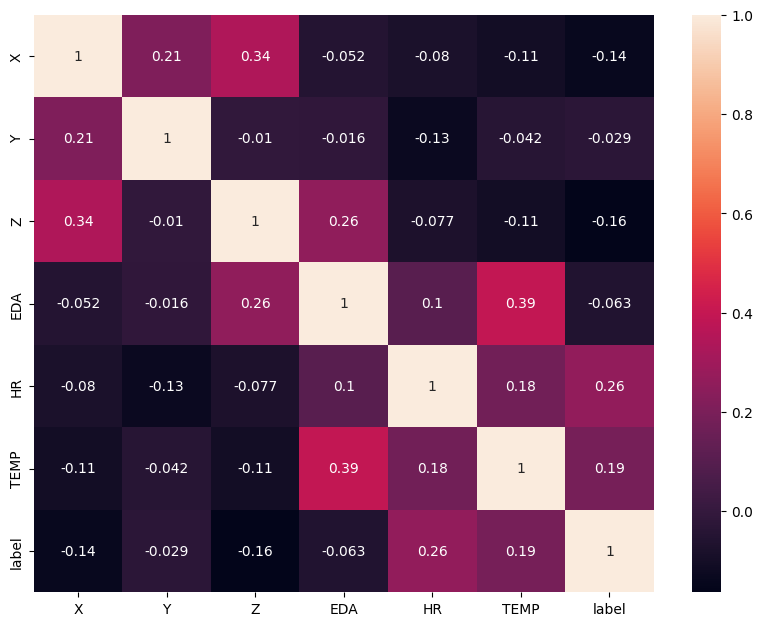

In [21]:
# Creates a heatmap of the correlation matrix
sns.heatmap(corr, annot=True)

# Shows the plot
plt.show()

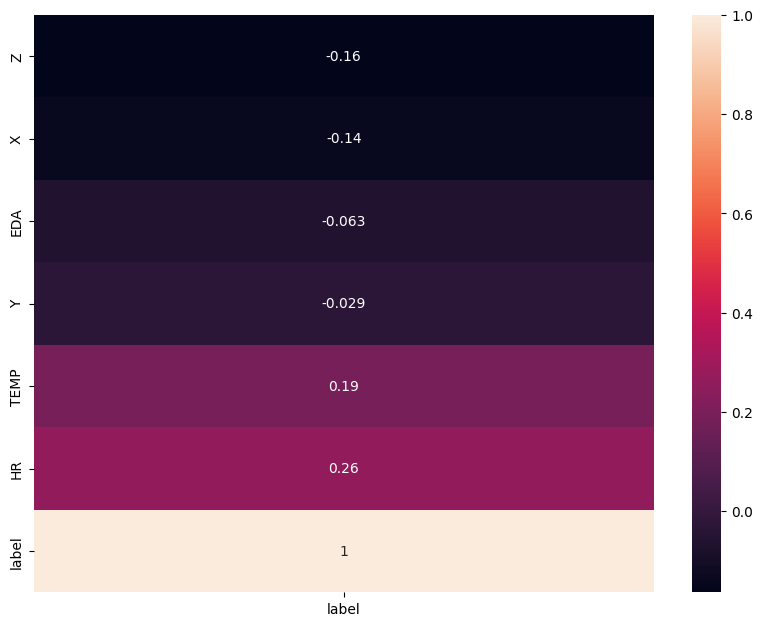

In [22]:
# Creates a heatmap of the correlation matrix with "label" columns only
sns.heatmap(pd.DataFrame(corr.label.sort_values()), annot=True)

# Shows the plot
plt.show()

In [23]:
# Calculates the correlation matrix for the raw data frame,
# after dropping the "datetime" and "id" columns
corr = df_raw.drop(["datetime", "id"], axis=1).corr()

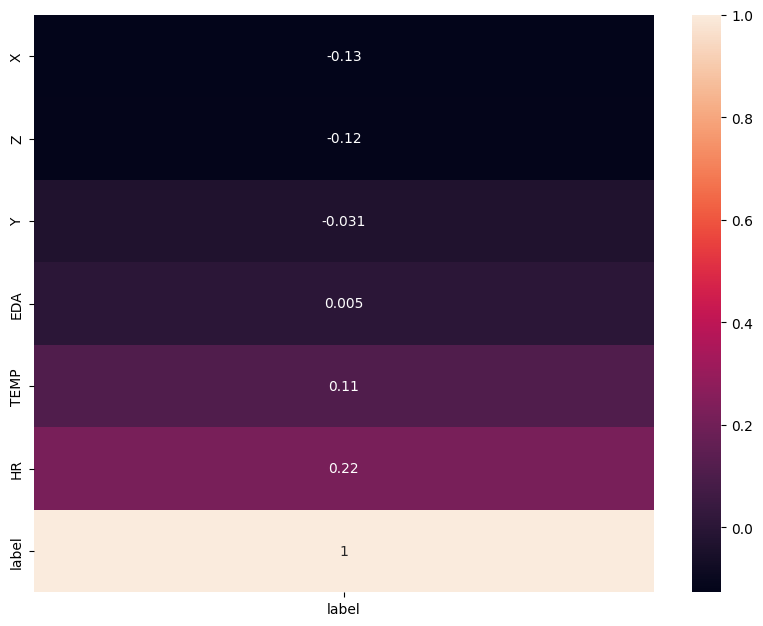

In [24]:
# Creates a heatmap of the correlation matrix with "label" columns only
sns.heatmap(pd.DataFrame(corr.label.sort_values()), annot=True)

# Shows the plot
plt.show()

In [25]:
# Creates a new column by combining datetime and label information into a string
hue = df[["datetime", "label"]].apply(
    lambda row: f"{str(row.datetime.date())}, {row.label}", axis=1)

# Renames the new column to "Date, Label"
hue.name = "Date, Label"


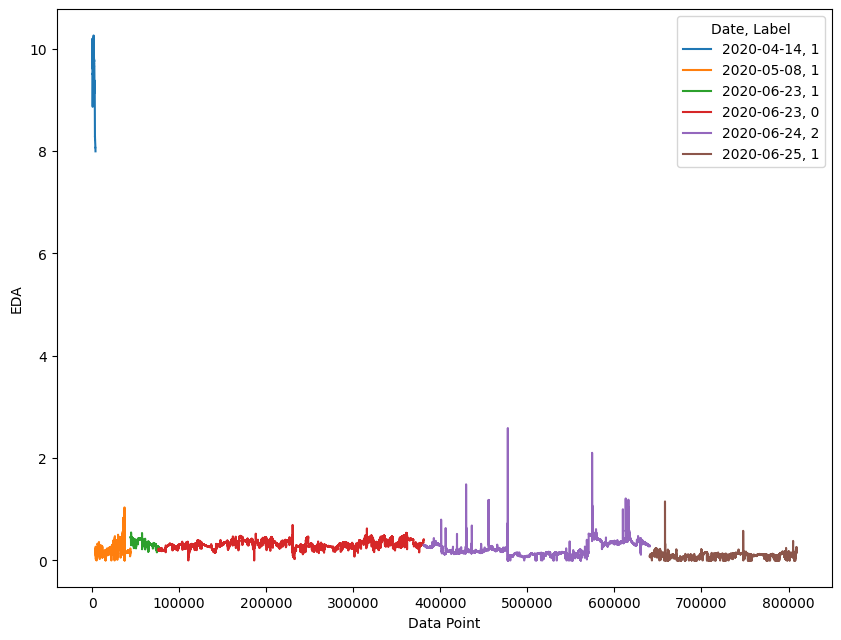

In [26]:
"""
The x and y axes are labeled for clarity, and a legend is included to show the meaning of the different colors in the plot.
"""
# Plots the EDA data to identify any patterns or trends in the data.
# Hue (legend) => (Date, Label)
sns.lineplot(data=df, x=df.index, y="EDA", hue=hue)

# Adds labels to the x and y axes
plt.xlabel("Data Point")
plt.ylabel("EDA")

# Shows the plot
plt.show()

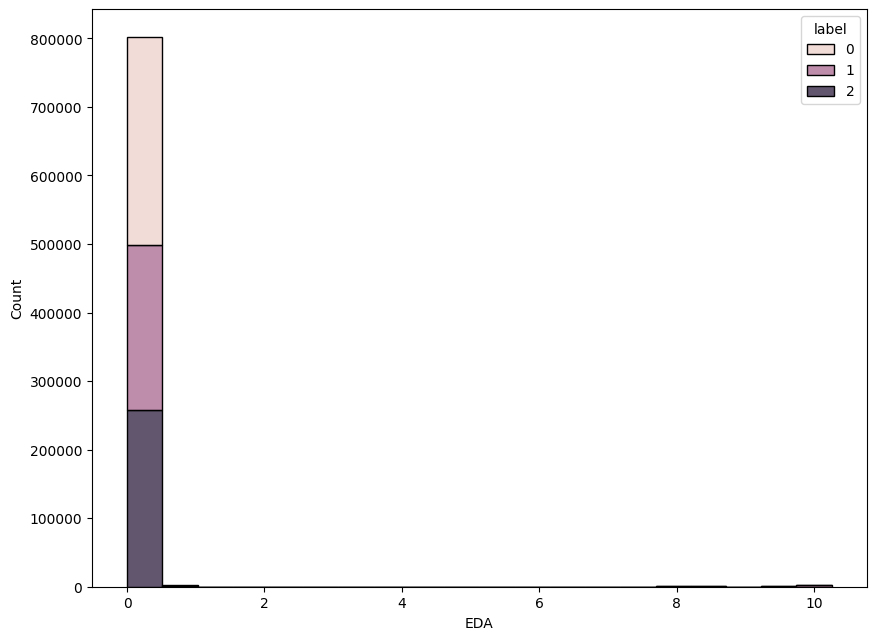

In [27]:
# Plots a histogram to display the count of each label in the EDA column
sns.histplot(
    data=df,
    x="EDA",
    bins=20,
    hue="label",
    multiple="stack"
)

# Shows the plot
plt.show()

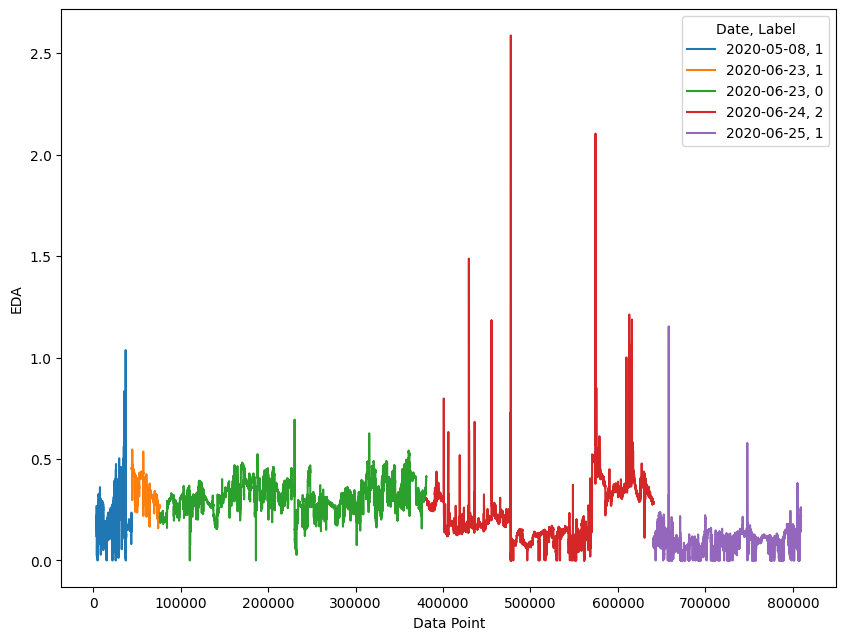

In [28]:
# Defines the excluded date to create a filter
excluded_date = datetime.strptime("2020-04-14", "%Y-%m-%d").date()

# Creates an array of indexes for data points that are not on the excluded date
included_indexes = np.where((df.datetime.dt.date != excluded_date) == True)[0]

# Plots the EDA data points that are not on the excluded date
sns.lineplot(data=df.iloc[included_indexes], x=included_indexes, y="EDA", hue=hue.iloc[included_indexes])

# Adds labels to the x and y axes
plt.xlabel("Data Point")
plt.ylabel("EDA")

# Shows the plot
plt.show()

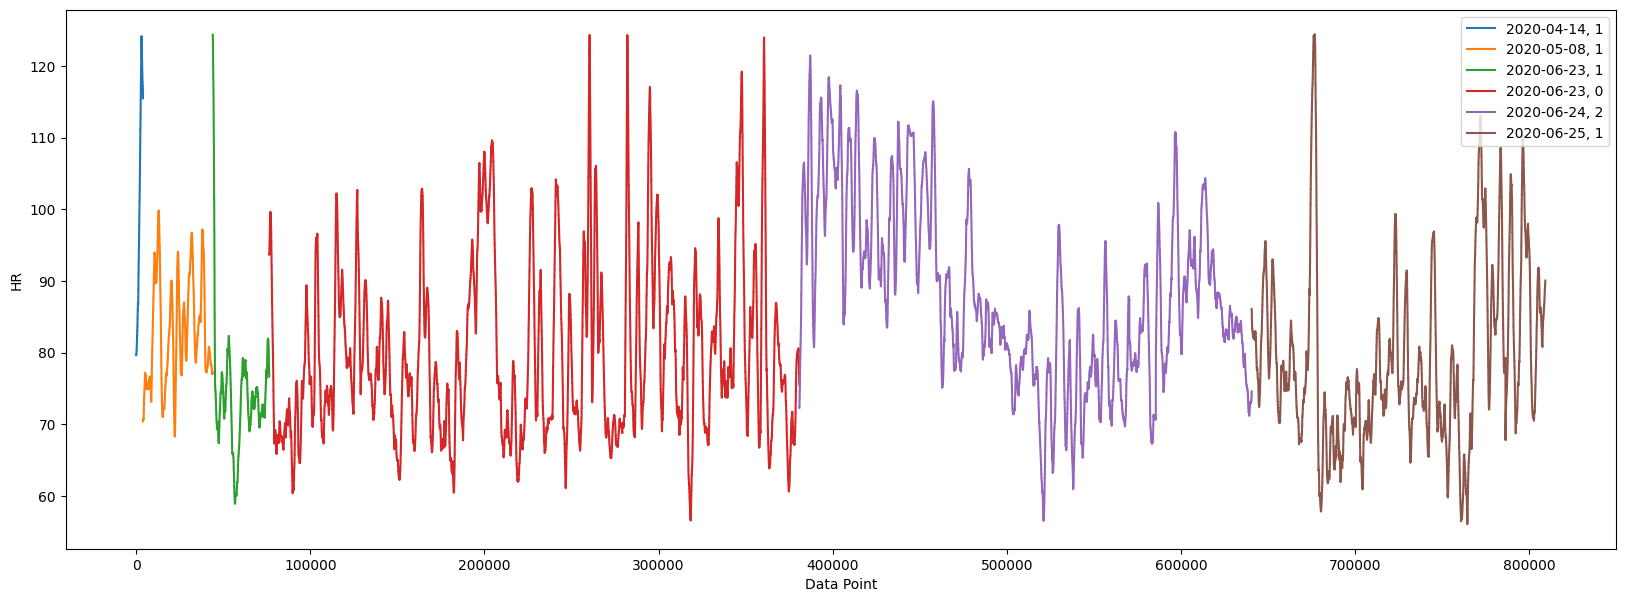

In [29]:
fig, ax = plt.subplots(figsize=(20, 7))

# Plots a line graph of HR data for each label
sns.lineplot(data=df, x=df.index, y="HR", hue=hue)

# Adds labels to the x and y axes
plt.xlabel("Data Point")
plt.ylabel("HR")

# Sets the location of the legend
plt.legend(loc="upper right")

# Shows the plot
plt.show()

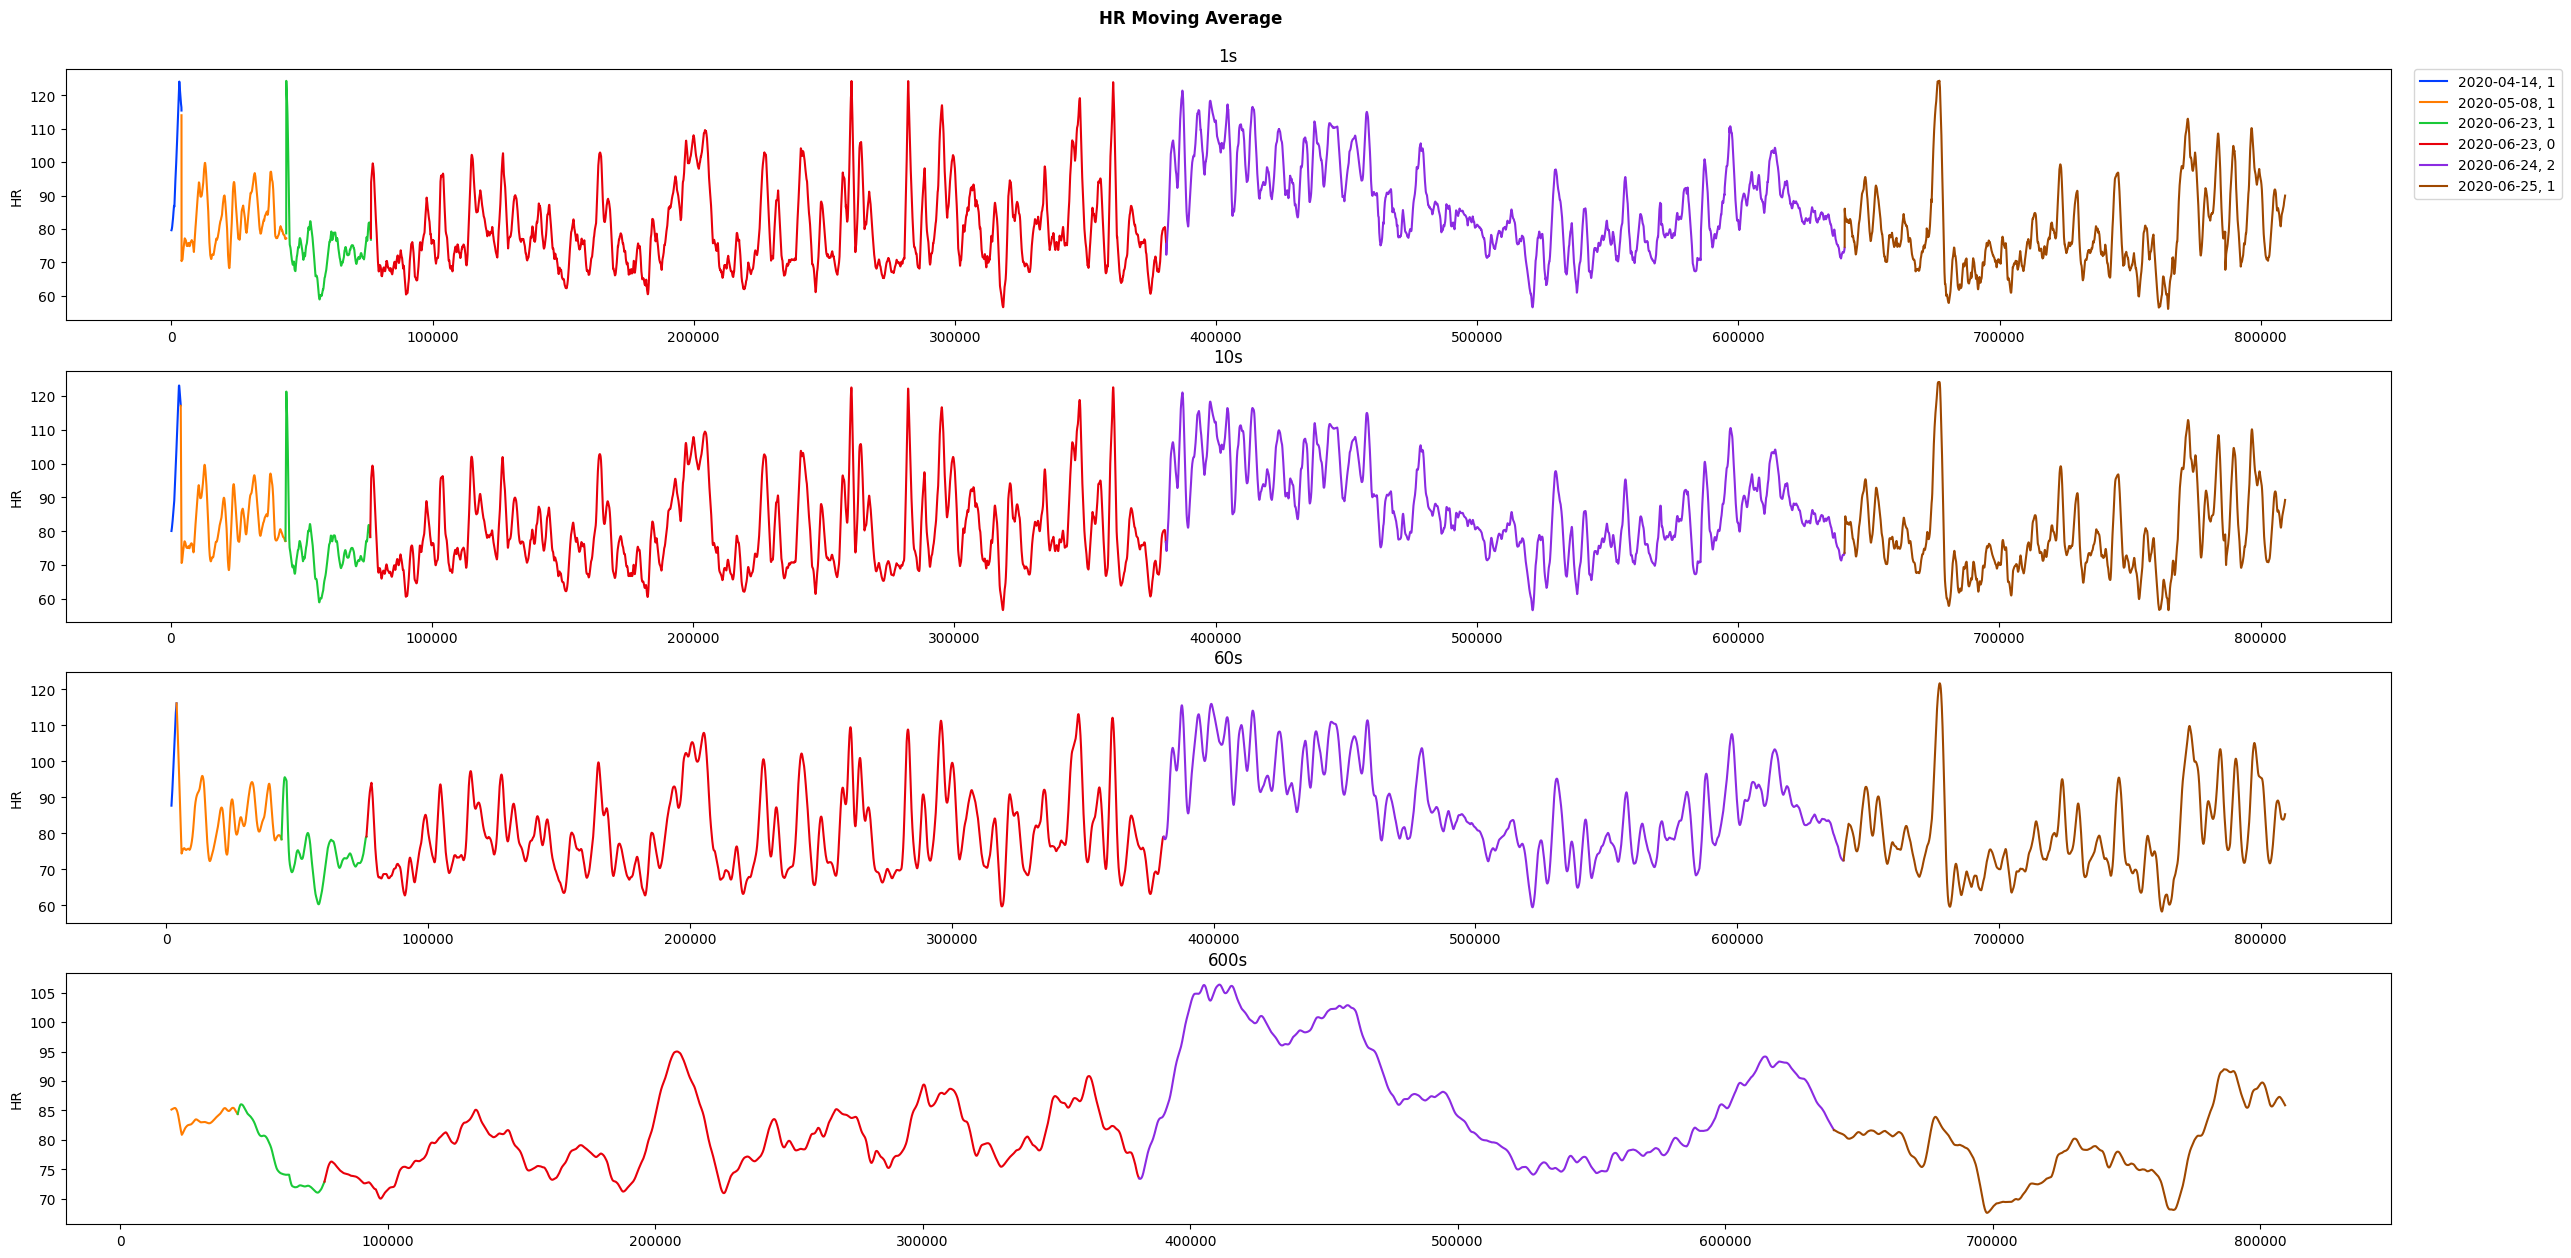

In [30]:
fig, axs = plt.subplots(4, 1, figsize=(30, 15))

# Defines a colour palette which consist of colour codes as much unique values in hue as.
palette = sns.color_palette("bright")[:hue.unique().size]

# Defines a function that helps to customise kwargs
# for each plot to apply DRY principle
def lineplot_kwargs(window=32):
    df_hr_ma = df["HR"].rolling(window=window).mean()
    return {
        "x": np.arange(0, len(df_hr_ma), 1.0),
        "y": df_hr_ma,
        "hue": hue,
        "palette": palette
    }

# df_hr_ma.reset_index(inplace=True, drop=True)

# Plots a line graph of Moving Average o HR data for each label.
# Each plot has different window values.

sns.lineplot(
    ax=axs[0],
    **lineplot_kwargs(window=32)
)
axs[0].legend(
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    borderaxespad=0.
)
axs[0].set_title("1s")

sns.lineplot(
    ax=axs[1],
    **lineplot_kwargs(window=320)
)
axs[1].get_legend().remove()
axs[1].set_title("10s")

sns.lineplot(
    ax=axs[2],
    **lineplot_kwargs(window=1920)
)
axs[2].get_legend().remove()
axs[2].set_title("60s")

sns.lineplot(
    ax=axs[3],
    **lineplot_kwargs(window=19200)
)
axs[3].get_legend().remove()
axs[3].set_title("600s")

# Sets a main title
fig.suptitle("HR Moving Average", y=0.92, fontweight="bold")

# Shows the plot
plt.show()

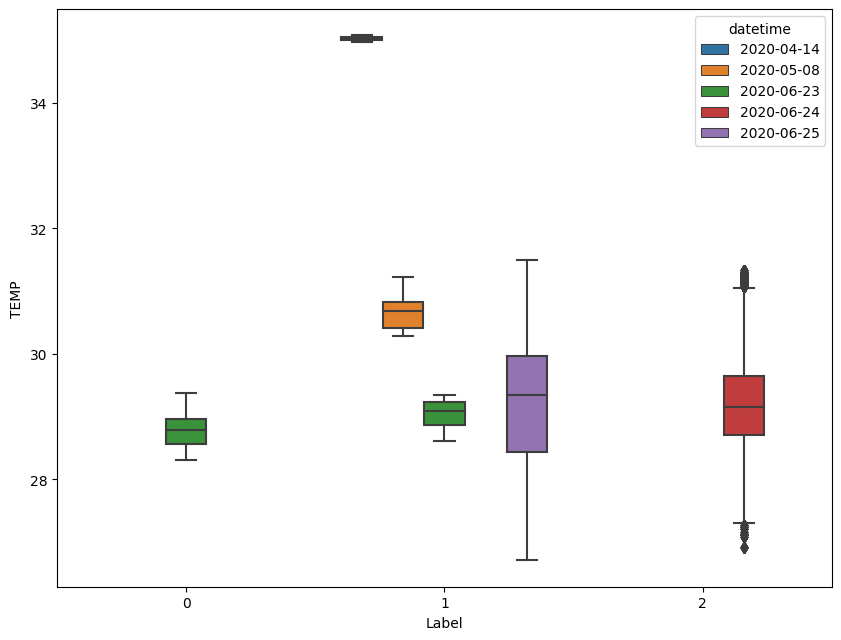

In [31]:
# Creates a boxplot of the TEMP data, grouped by the LABEL column, with the addition of a hue for the datetime dates
sns.boxplot(
    x="label",
    y="TEMP",
    hue=df.datetime.dt.date,
    data=df,
    order=[0, 1, 2]
)

# Adds a label to the x-axis
plt.xlabel("Label")

# Adds a label to the y-axis
plt.ylabel("TEMP")

# Shows the plot
plt.show()

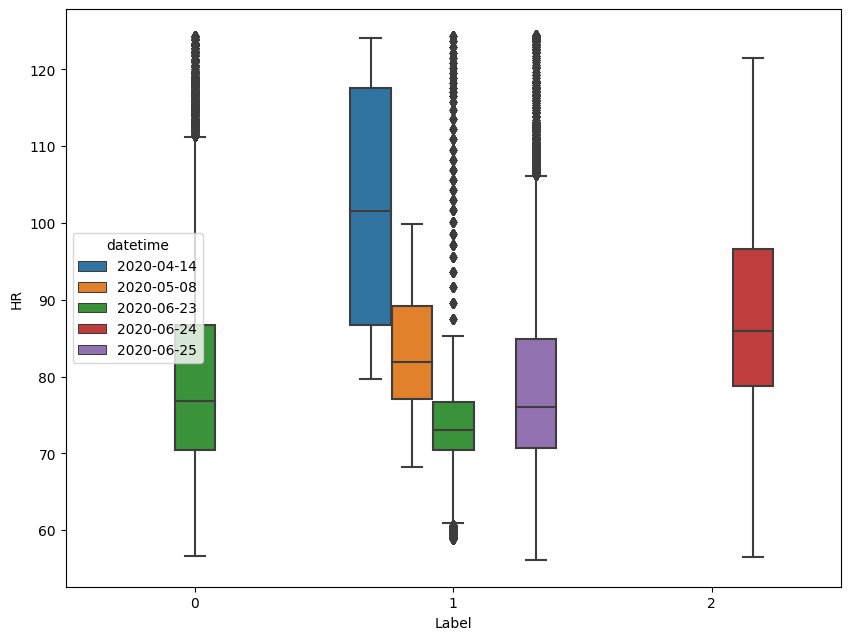

In [32]:
# Creates a boxplot of the HR data, grouped by the LABEL column, with the addition of a hue for the datetime dates
sns.boxplot(
    x="label",
    y="HR",
    hue=df.datetime.dt.date,
    data=df,
    order=[0, 1, 2]
)

# Adds a label to the x-axis
plt.xlabel("Label")

# Adds a label to the y-axis
plt.ylabel("HR")

# Shows the plot
plt.show()

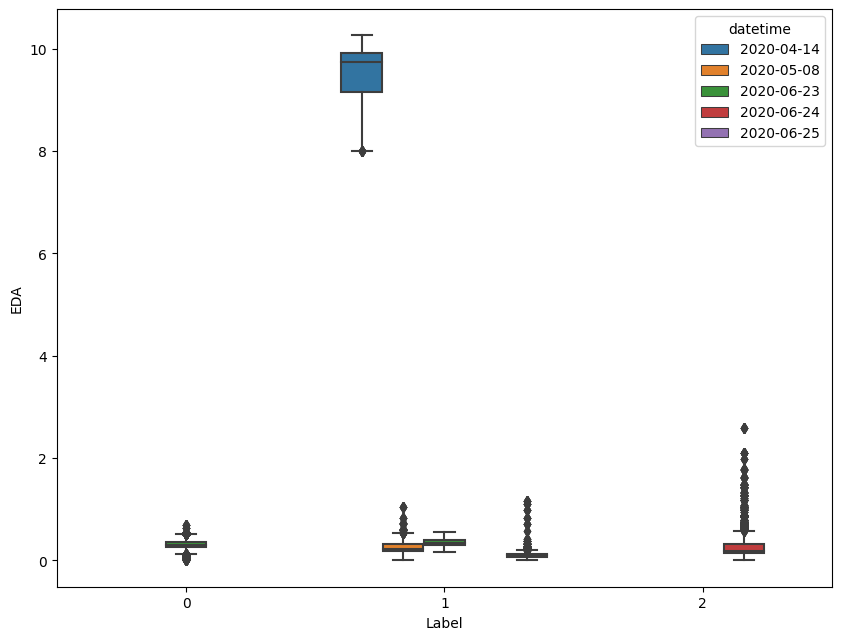

In [33]:
# Creates a boxplot of the EDA data, grouped by the LABEL column, with the addition of a hue for the datetime dates
sns.boxplot(
    x="label",
    y="EDA",
    hue=df.datetime.dt.date,
    data=df,
    order=[0, 1, 2]
)

# Adds a label to the x-axis
plt.xlabel("Label")

# Adds a label to the y-axis
plt.ylabel("EDA")

# Shows the plot
plt.show()

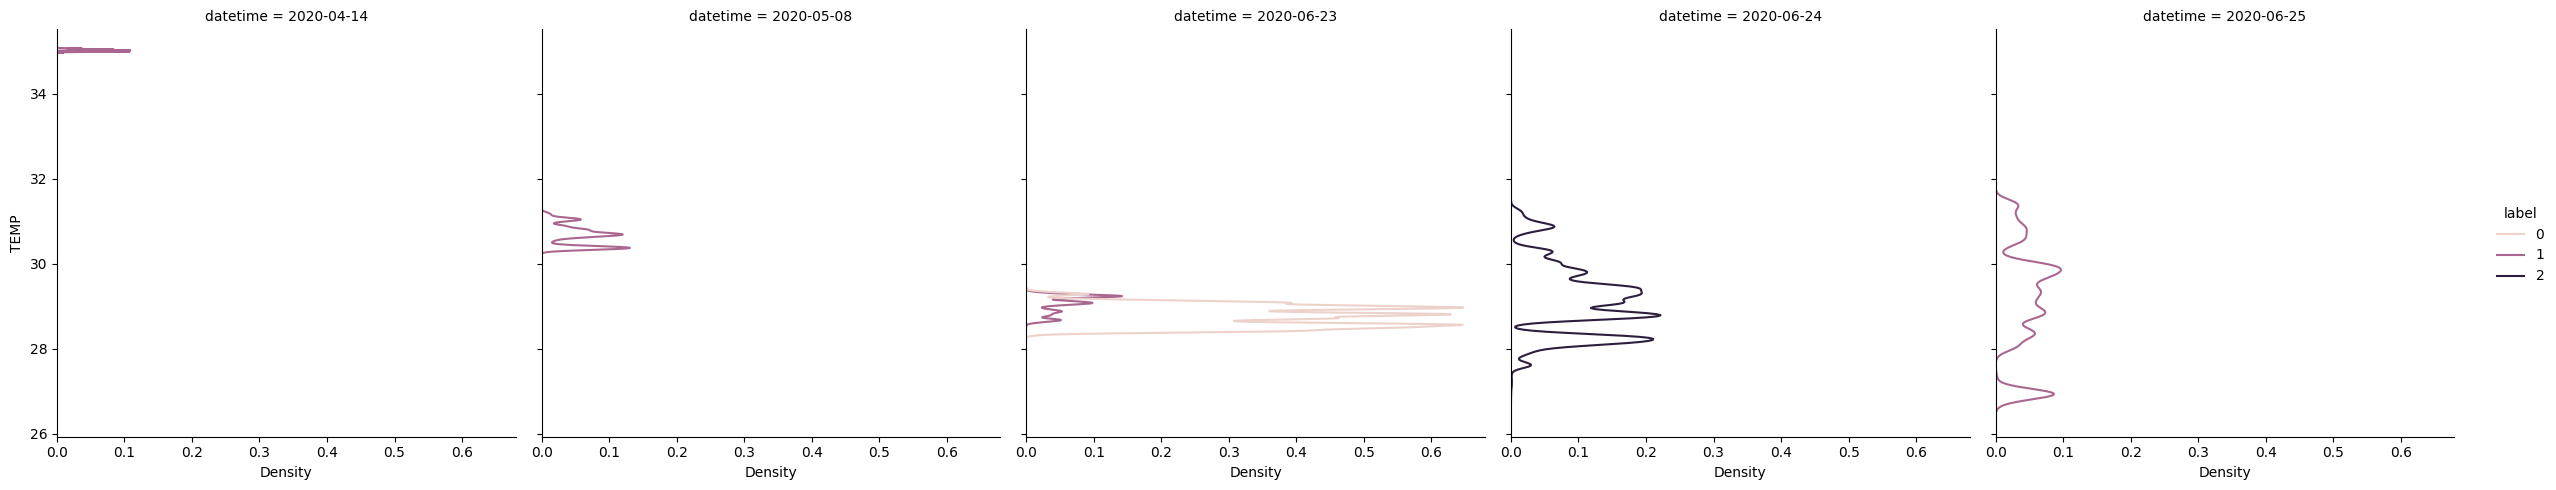

In [34]:
# Plots a displot for the temperature feature with respect to label, date and value of the variable
sns.displot(
    data=df,
    y="TEMP",
    hue="label",
    col=df.datetime.dt.date,
    kind="kde",
    height=5,
    aspect=1,
)

# Shows the plot
plt.show()

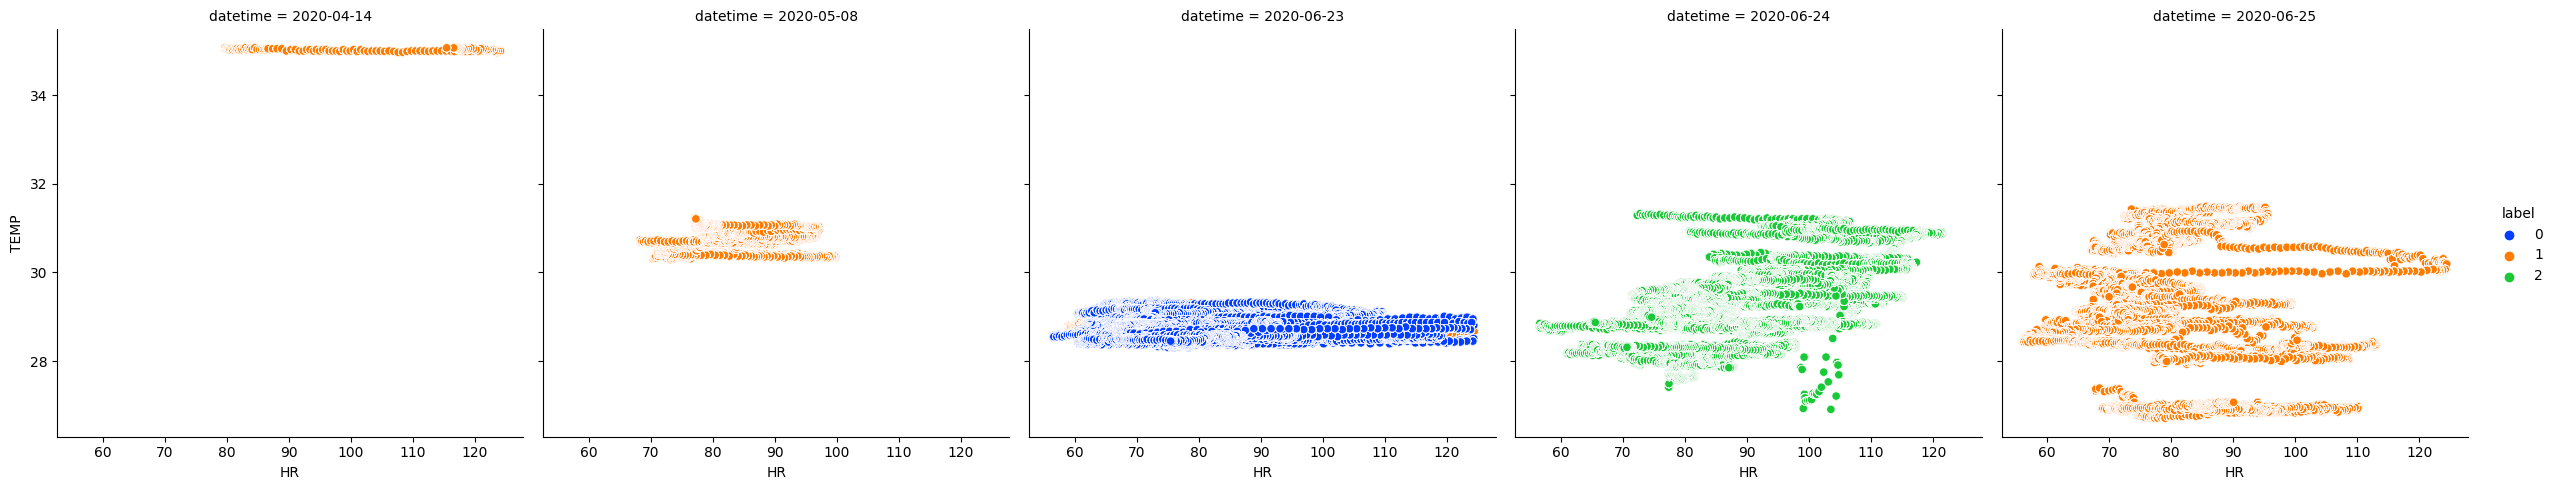

In [35]:
# Plots HR vs TEMP data for each label and date in separate columns
sns.relplot(data=df, x="HR", y="TEMP", hue="label", col=df.datetime.dt.date, palette=palette[:3])

# Shows the plot
plt.show()

In [ ]:
# Plots X, Y and Z features of ACC (Accelerometer) in 3D Scatter form
fig = px.scatter_3d(
    df.sample(10_000),
    x="X",
    y="Y",
    z="Z",
    color="label",
)
fig.show()

In [36]:
"""
Describes the ACC values so that
min and max values can be seen
in order to understand about how
to visualize them.
"""
df[["X", "Y", "Z"]].describe()

,X,Y,Z
count,809350.000000,809350.000000,809350.000000
mean,-33.415937,3.752952,27.813198
std,24.704878,29.909400,29.236906
min,-109.000000,-90.000000,-76.000000
25%,-57.000000,-3.000000,5.000000
50%,-34.000000,4.000000,29.000000
75%,-20.000000,15.000000,56.000000
max,44.000000,93.000000,127.000000


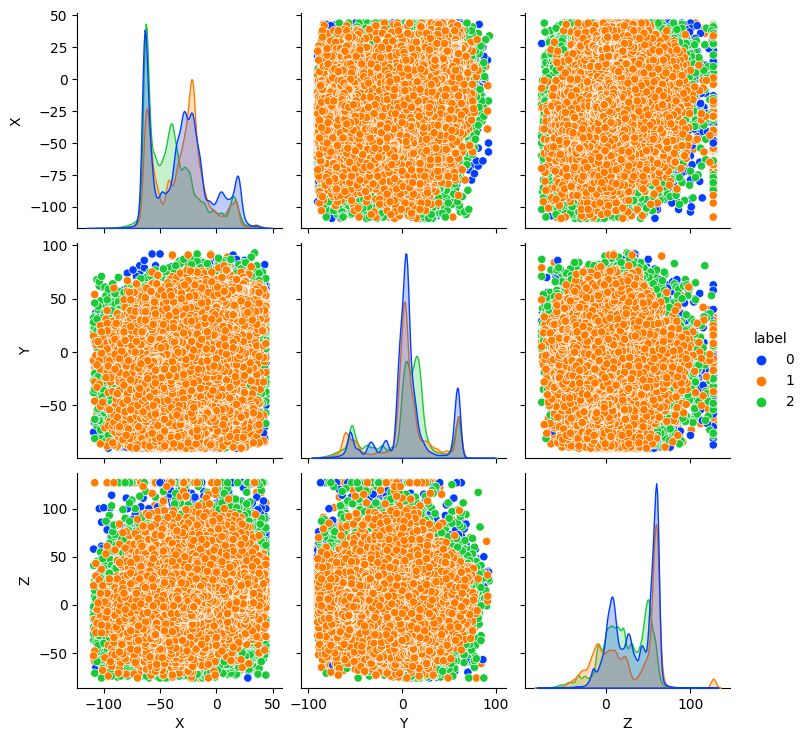

In [37]:
sns.pairplot(data=df[["X", "Y", "Z", "label"]], hue="label", palette=sns.color_palette("bright")[:3])
plt.show()

In [38]:
df_melt = pd.melt(df, id_vars=["label", "datetime"], value_vars=["X", "Y", "Z"])
df_melt.datetime = df_melt.datetime.dt.date
df_melt.rename(
    columns={
        "variable": "ACC Axis",
        "value": "Value",
    },
    errors="raise",
    inplace=True)
df_melt

,label,datetime,ACC Axis,Value
0,1,2020-04-14,X,-56.0
1,1,2020-04-14,X,-56.0
2,1,2020-04-14,X,-62.0
3,1,2020-04-14,X,-64.0
4,1,2020-04-14,X,-59.0
...,...,...,...,...
2428045,1,2020-06-25,Z,-11.0
2428046,1,2020-06-25,Z,-5.0
2428047,1,2020-06-25,Z,-2.0
2428048,1,2020-06-25,Z,-2.0


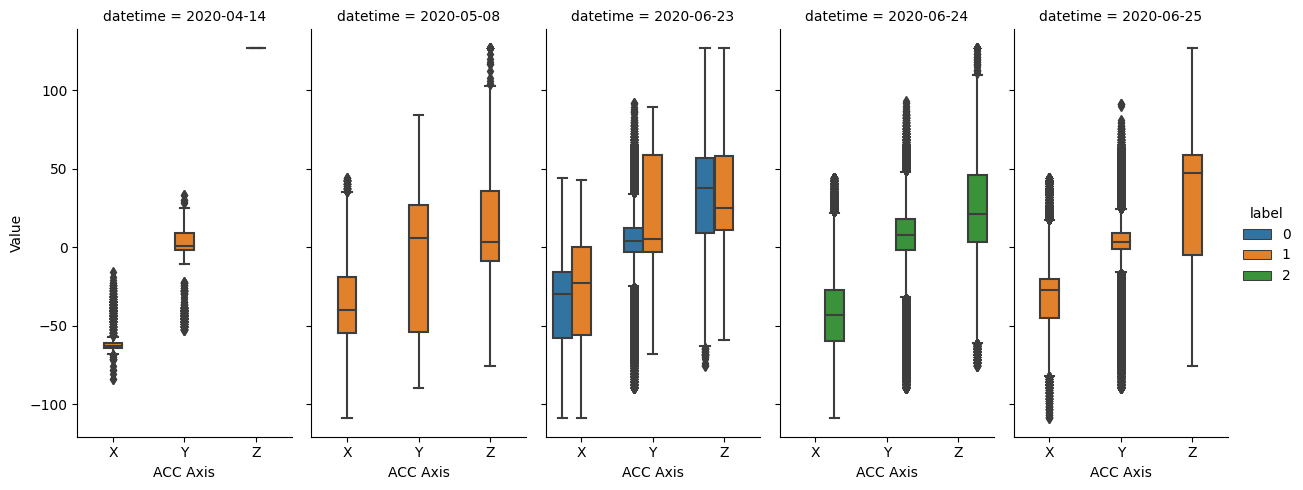

In [39]:
sns.catplot(
    data=df_melt,
    x="ACC Axis",
    y="Value",
    hue="label",
    col="datetime",
    aspect=.5,
    kind="box"
)

/Users/kaanberkeugurlar/.pyenv/versions/3.10.6/envs/ai/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


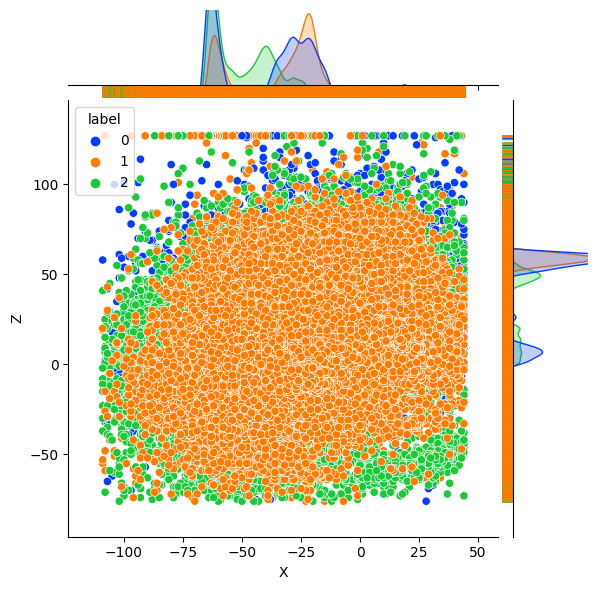

In [40]:
g = sns.jointplot(data=df, x="X", y="Z", hue="label", palette=sns.color_palette("bright")[:3])
# g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
plt.show()

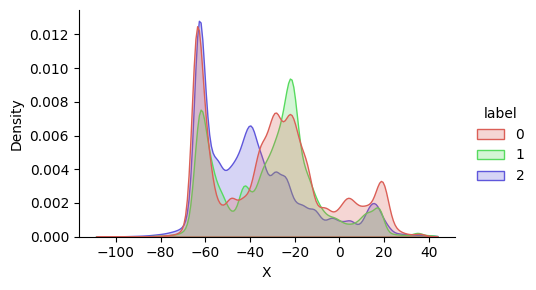

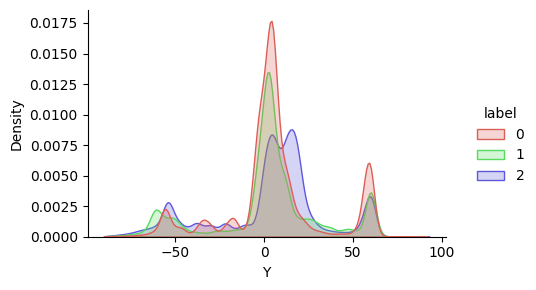

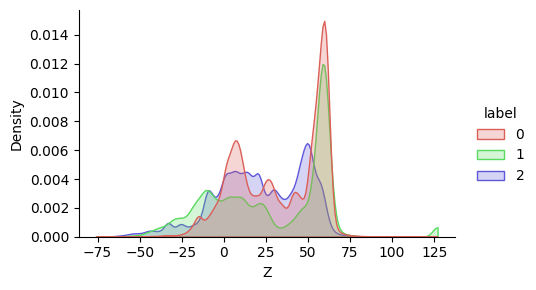

In [41]:
kwargs = {
    "data":df,
    "kind":"kde",
    #"hue":hue,
    "hue":"label",
    "fill":True,
    "legend":True,
    "aspect":1.6,
    "height": 3,
    "cut":0,
    "bw_adjust":1,
    "palette":sns.color_palette("hls", 3), # len(hue.unique())]
}

sns.displot(
    x="X",
    **kwargs
)

sns.displot(
    x="Y",
    **kwargs
)

sns.displot(
    x="Z",
    **kwargs
)

plt.show()

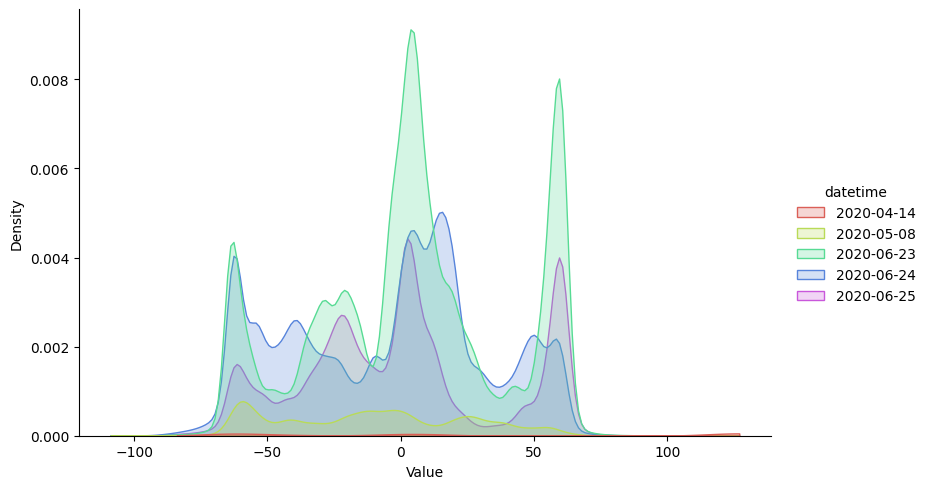

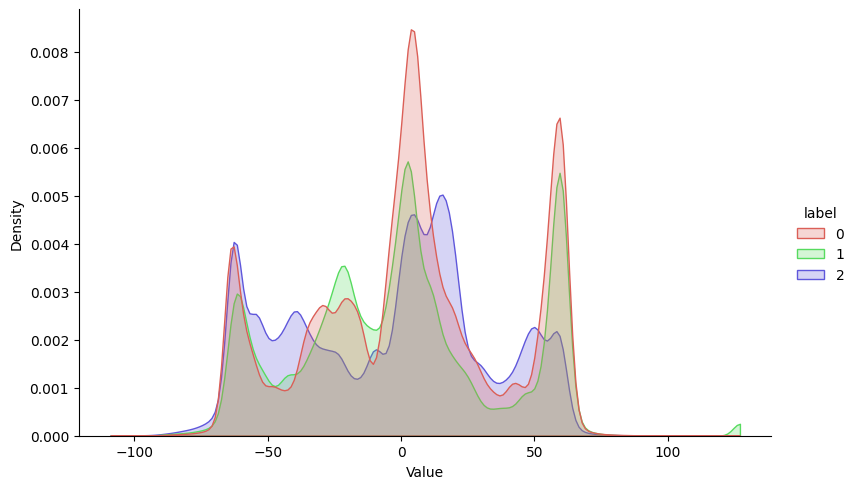

In [42]:
sns.displot(data=df_melt, hue="datetime", x="Value",
            kind="kde", fill=True, legend=True, aspect=1.6, 
            cut=0, bw_adjust=1, color="red", palette=sns.color_palette("hls", 5))

sns.displot(data=df_melt, hue="label", x="Value",
            kind="kde", fill=True, legend=True, aspect=1.6, 
            cut=0, bw_adjust=1, color="red", palette=sns.color_palette("hls", 3))
plt.show()

In [ ]:
for label in df.label.unique():
    fig = px.histogram(df.query(f"label == {label}")[["X", "Y", "Z"]], height=250, barmode="stack", title=f"Stress level: {STRESS_LEVEL[label]}")
    # fig.update_traces(contours_coloring="fill", contours_showlabels = True)
    fig.show()

In [ ]:
fig = px.density_contour(
    df_melt,
    x="ACC Axis",
    y="Value",
    height=1500,
)
fig.show()

---

## DATA FEATURE EXTRACTION

#### Insights From The Relevant Paper
For our stress detection, we use a frequency of 4 Hz to minimize information loss; this provided higher accuracy with a reasonable computation time on the pre-trained data that was used to predict the stress level.

Our analysis shows that the computation time increases as the sampling frequency of the signals increase.

We observed that as the window size increases, the accuracy of stress detection decreases.

Similarly, the accuracy is higher for higher frequencies. However, higher frequencies also result in an increase in computation time. (__**Fair Trade-off**__)

[[A multimodal sensor dataset for
continuous stress detection of
nurses in a hospital](https://www.nature.com/articles/s41597-022-01361-y#:~:text=The%20stress%20detection%20algorithm%20uses,data%20were%20detected%20as%20stressful.)]

#### Preprocess Technique
The purpose of applying this kind of preprocessing is to introduce temporal dependencies between the features in the dataset, which can help capture the temporal dynamics of the nurses' stress levels. By using a lag of 1 to 10 time steps, the new DataFrame includes information from the past in addition to the current measurements, which can provide a more comprehensive representation of the nurses' physiological response to stress.

In [45]:
for name, group in df_grouped_date:
    print(name, group.shape)

2020-04-14 (3872, 8)
2020-05-08 (40099, 8)
2020-06-23 (336958, 8)
2020-06-24 (259773, 8)
2020-06-25 (168648, 8)


In [46]:
freq = 1 / next(iter(df_grouped_date))[1].datetime.diff().mean().total_seconds()
print(freq)

24.199012680282646


In [47]:
cols_to_process = [
    "EDA",
    "HR",
    "TEMP"
]
cols_to_create = [
    "EDA_Min",
    "EDA_Max",
    "EDA_Mean",
    "EDA_Std",
    "EDA_Skew",
    "EDA_Kurtosis",
    "EDA_Num_Peaks",
    "EDA_Amphitude",
    "EDA_Duration",
    "HR_Min",
    "HR_Max",
    "HR_Mean",
    "HR_Std",
    "HR_RMS",
    "TEMP_Min",
    "TEMP_Max",
    "TEMP_Mean",
    "TEMP_Std",
    "TEMP_RMS",
    "label"
]

df_signals = df[cols_to_process]
df_features = pd.DataFrame(columns=cols_to_create)

for i in tqdm(range(0, df.EDA.size, 16)):
    df_sliced = df.iloc[i: i+32]
    label = df_sliced.label.mode()[0]

    if df_sliced.size < 32:
        continue
        
    result = []
    
    # EDA
    # Statistical features
    result = result + list(stats(df_sliced[cols_to_process[0]]))
    # Shape features
    result = result + list(shape_features(df_sliced[cols_to_process[0]]))
    # Peak properties
    peaks, properties = find_peaks(df_sliced[cols_to_process[0]], width=5)
    # Number of peaks
    result = result + [len(peaks)]
    # Amphitude
    result = result + [np.sum(properties["prominences"])]
    # Duration
    result = result + [np.sum(properties["widths"])]
    
    # HR
    # Statistical features
    result = result + list(stats(df_sliced[cols_to_process[1]]))
    # Root Mean Square
    result = result + [rms(df_sliced[cols_to_process[1]])]
    
    # TEMP
    # Statistical features
    result = result + list(stats(df_sliced[cols_to_process[2]]))
    # Root Mean Square
    result = result + [rms(df_sliced[cols_to_process[2]])]
    
    result = result + [label]
    
    df_features.loc[i/16] = result

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50585/50585 [01:02<00:00, 805.10it/s]


In [48]:
df_features.head()

,EDA_Min,EDA_Max,EDA_Mean,EDA_Std,EDA_Skew,EDA_Kurtosis,EDA_Num_Peaks,EDA_Amphitude,EDA_Duration,HR_Min,HR_Max,HR_Mean,HR_Std,HR_RMS,TEMP_Min,TEMP_Max,TEMP_Mean,TEMP_Std,TEMP_RMS,label
0.0,9.746603,9.986155,9.913136,0.097514,-1.062513,-0.746204,1.0,0.034587,7.574999,79.63,79.63,79.630,0.000,0.000000,35.07,35.07,35.07,0.0,0.0,1.0
1.0,9.746603,10.045082,9.948365,0.119061,-1.013433,-0.786662,0.0,0.000000,0.000000,79.63,79.70,79.665,0.035,0.012572,35.07,35.07,35.07,0.0,0.0,1.0
2.0,10.018180,10.141158,10.057251,0.049452,1.022084,-0.782088,1.0,0.020496,7.880938,79.70,79.70,79.700,0.000,0.000000,35.07,35.07,35.07,0.0,0.0,1.0
3.0,10.018180,10.141158,10.085434,0.044195,-0.372820,-1.025393,1.0,0.057646,7.916205,79.70,79.75,79.725,0.025,0.008980,35.07,35.07,35.07,0.0,0.0,1.0
4.0,10.042520,10.098885,10.073905,0.020686,-0.408800,-1.131721,0.0,0.000000,0.000000,79.75,79.75,79.750,0.000,0.000000,35.07,35.07,35.07,0.0,0.0,1.0


In [49]:
df_features.shape

(50585, 20)

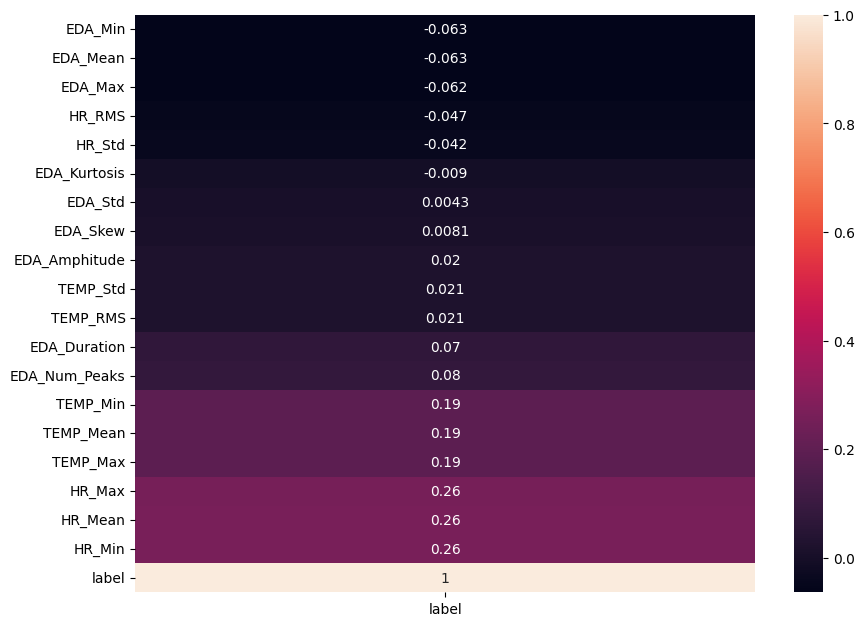

In [50]:
corr = df_features.corr()
sns.heatmap(pd.DataFrame(corr.label.sort_values()), annot=True)
plt.show()

In [51]:
features_to_shift = [
    "EDA_Mean",
    "HR_Mean",
    "TEMP_Mean"
]
cols = [f"{x}_{i}" for x in features_to_shift for i in range(10, 0, -1)]
df_lag_features = pd.DataFrame(columns=cols)

In [52]:
df_lag_features = pd.concat([df_features[x].shift(i) for i in range(10, 0, -1) for x in features_to_shift], axis=1)
df_lag_features.columns = cols
df_lag_features = df_lag_features.dropna()

In [53]:
df_lag_features.shape

(50575, 30)

In [54]:
df_processed = pd.concat([df_lag_features, df_features.iloc[10:]], axis=1)
df_processed.reset_index(drop=True, inplace=True)

In [55]:
df_processed.head()

,EDA_Mean_10,EDA_Mean_9,EDA_Mean_8,EDA_Mean_7,EDA_Mean_6,EDA_Mean_5,EDA_Mean_4,EDA_Mean_3,EDA_Mean_2,EDA_Mean_1,...,HR_Max,HR_Mean,HR_Std,HR_RMS,TEMP_Min,TEMP_Max,TEMP_Mean,TEMP_Std,TEMP_RMS,label
0,9.913136,79.630,35.07,9.948365,79.665,35.07,10.057251,79.700,35.07,10.085434,...,80.08,80.080,0.000,0.000000,35.05,35.05,35.05,0.00,0.000000,1.0
1,9.948365,79.665,35.07,10.057251,79.700,35.07,10.085434,79.725,35.07,10.073905,...,80.27,80.175,0.095,0.034125,35.05,35.05,35.05,0.00,0.000000,1.0
2,10.057251,79.700,35.07,10.085434,79.725,35.07,10.073905,79.750,35.07,10.020422,...,80.27,80.270,0.000,0.000000,35.05,35.05,35.05,0.00,0.000000,1.0
3,10.085434,79.725,35.07,10.073905,79.750,35.07,10.020422,79.760,35.07,10.020742,...,80.43,80.350,0.080,0.028737,35.03,35.05,35.04,0.01,0.003592,1.0
4,10.073905,79.750,35.07,10.020422,79.760,35.07,10.020742,79.770,35.07,10.024265,...,80.43,80.430,0.000,0.000000,35.03,35.03,35.03,0.00,0.000000,1.0
